# Test the added class, JumpSizeDirectionTrueProb, in models.py

In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Load neccessary modules
import models
import mscthesis
import os
from pathlib import Path
import pandas as pd
import numpy as np

In [3]:
## Define data path
data_path = os.path.join(Path(os.getcwd()).parent, 'dbs/')
geotweets_path = os.path.join(data_path, "sweden/geotweets.csv")

## 1 Load and process tweets

In [4]:
geotweets = mscthesis.read_geotweets_raw(geotweets_path).set_index('userid')

# this code should be somewhere else...
geotweets = geotweets[(geotweets['weekday'] < 6) & (0 < geotweets['weekday'])]
home_visits = geotweets.query("label == 'home'").groupby('userid').size()
geotweets = geotweets.loc[home_visits.index]
tweetcount = geotweets.groupby('userid').size()
geotweets = geotweets.drop(labels=tweetcount[tweetcount < 20].index)
regioncount = geotweets.groupby(['userid', 'region']).size().groupby('userid').size()
geotweets = geotweets.drop(labels=regioncount[regioncount < 2].index)
# Ensure the tweets are sorted chronologically
geotweets = geotweets.sort_values(by=['userid', 'createdat'])

geotweets.head()

,region,createdat,tweetid,latitude,longitude,month,weekday,hourofday,timezone,ym,label,geometry
userid,,,,,,,,,,,,
5616,6,2013-03-11 07:50:00+00:00,311021173670555648,59.405498,17.954750,3,1,8,Europe/Stockholm,2013-03,other,POINT (17.95475 59.40550)
5616,5,2013-03-13 08:55:34+00:00,311762446530535425,59.428862,17.947206,3,3,9,Europe/Stockholm,2013-03,home,POINT (17.94721 59.42886)
5616,7,2013-03-13 10:02:14+00:00,311779226460237824,59.436478,17.937756,3,3,11,Europe/Stockholm,2013-03,other,POINT (17.93776 59.43648)
5616,7,2013-03-13 11:21:46+00:00,311799240374505472,59.437367,17.937031,3,3,12,Europe/Stockholm,2013-03,other,POINT (17.93703 59.43737)
5616,7,2013-03-13 11:21:46+00:00,311799240684892160,59.437367,17.937031,3,3,12,Europe/Stockholm,2013-03,other,POINT (17.93703 59.43737)


## 2 Select one individual for testing

In [5]:
uid = 16270243
u_tweets = geotweets.loc[uid]
tst = models.JumpSizeDirectionTrueProb()
tst.fit(u_tweets)
tst.sample()

(236.38992948342116, 6998.893595366878)

## 3 Visualise the jump size and bearing
Jump size is dependent on bearing, therefore, the modification is neccessary to deliver a more realistic mobility sequence.

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


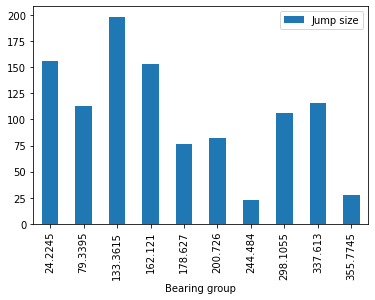

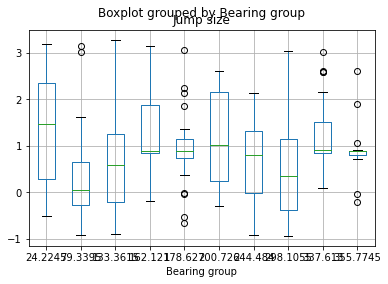

In [8]:
df = pd.DataFrame(tst.bearings, columns=("Bearing",))
df.loc[:, "Jump size"] = tst.jump_sizes_km
df.loc[:, "Bearing group"] = pd.cut(df.Bearing, bins=[np.quantile(df.Bearing, _/10) for _ in range(0, 11)])
df.loc[:, "Bearing group"] = df.loc[:, "Bearing group"].apply(lambda x: x.mid)
df_m = df.groupby("Bearing group").agg({"Jump size": "mean"}).reset_index()
df_m.plot.bar(x="Bearing group", y="Jump size")

df.loc[:, "Jump size"] = np.log10(df.loc[:, "Jump size"])
df.boxplot(by="Bearing group", column="Jump size")

## 4 Generate a sequence of visits with the model
Test if the new class functions normally.

In [9]:
visit_factory = models.Sampler(
    model=models.PreferentialReturn(
        p=.4,
        gamma=.75,
        region_sampling=models.RegionTransitionZipf(beta=.03, zipfs=1.2),
    ),
    n_days=7 * 20,
    daily_trips_sampling=models.NormalDistribution(mean=3.14, std=1.8),
    geotweets_path=geotweets_path,
)
visits = visit_factory.visits()
visits.head()

done with 250
done with 500
done with 750
done with 1000
done with 1250
done with 1500
done with 1750
done with 2000
done with 2250
done with 2500
done with 2750
done with 3000
done with 3250
done with 3500


,day,timeslot,kind,latitude,longitude,region
userid,,,,,,
5616,0,0,region,59.428862,17.947206,5
5616,0,1,region,59.405498,17.954750,6
5616,1,0,region,59.428862,17.947206,5
5616,1,1,region,59.405498,17.954750,6
5616,1,2,region,59.428862,17.947206,5
